In [1]:
DATA_ROOT = "/content/drive/MyDrive/Nifti-data"


In [5]:
import glob
import os

image_paths = glob.glob(DATA_ROOT + "/**/*.png", recursive=True)


print("Found images:", len(image_paths))
print("Example:", image_paths[:3])


Found images: 8096
Example: ['/content/drive/MyDrive/Nifti-data/BPD-Neo-09/lung_seg/slice_041.png', '/content/drive/MyDrive/Nifti-data/BPD-Neo-09/lung_seg/slice_046.png', '/content/drive/MyDrive/Nifti-data/BPD-Neo-09/lung_seg/slice_050.png']


In [6]:
import os

ROOT = "/content/drive/MyDrive/Nifti-data"

subjects = sorted([d for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT, d))])

for subj in subjects:
    subj_path = os.path.join(ROOT, subj)
    print(f"\n📁 {subj}")

    for folder in sorted(os.listdir(subj_path)):
        print("  └──", folder)



📁 BPD-Neo-01
  └── image
  └── lung_seg

📁 BPD-Neo-02
  └── image
  └── lung_seg
  └── trachea_seg
  └── trachea_seg_R2

📁 BPD-Neo-03
  └── image
  └── lung_seg

📁 BPD-Neo-04
  └── image
  └── lung_seg
  └── trachea_seg
  └── trachea_seg_R2

📁 BPD-Neo-05
  └── image
  └── lung_seg
  └── trachea_seg
  └── trachea_seg_R2

📁 BPD-Neo-06
  └── image
  └── lung_seg
  └── trachea_seg
  └── trachea_seg_R2

📁 BPD-Neo-07
  └── image
  └── lung_seg
  └── trachea_seg
  └── trachea_seg_R2

📁 BPD-Neo-08
  └── image
  └── lung_seg
  └── trachea_seg
  └── trachea_seg_R2

📁 BPD-Neo-09
  └── image
  └── lung_seg
  └── trachea_seg
  └── trachea_seg_R2

📁 BPD-Neo-10
  └── image
  └── lung_seg
  └── lung_seg_R2
  └── trachea_seg

📁 BPD-Neo-11
  └── image
  └── lung_seg
  └── lung_seg_R2

📁 BPD-Neo-12
  └── image
  └── lung_seg
  └── lung_seg_R2
  └── trachea_seg

📁 BPD-Neo-13
  └── image
  └── lung_seg
  └── lung_seg_R2
  └── trachea_seg

📁 BPD-Neo-14
  └── image
  └── lung_seg
  └── lung_seg_R2
  └── tra

In [7]:
import os
import random
import glob
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from skimage import img_as_float, exposure
from skimage.restoration import denoise_bilateral, denoise_nl_means, estimate_sigma
from skimage.filters import median
from skimage.morphology import disk
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
from skimage.util import random_noise

try:
    from bm3d import bm3d, BM3DProfile
    BM3D_AVAILABLE = True
except Exception:
    BM3D_AVAILABLE = False

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics


In [13]:
ROOT = "/content/drive/MyDrive/Nifti-data"

def find_patient_image_paths(root_dir):
    folders = []
    for p in sorted(os.listdir(root_dir)):
        full_p = os.path.join(root_dir, p, "image")
        if os.path.exists(full_p):
            folders.append(full_p)
    return folders

def list_png_images(folder):
    imgs = glob.glob(os.path.join(folder, "*.png"))
    imgs += glob.glob(os.path.join(folder, "*.jpg"))
    imgs += glob.glob(os.path.join(folder, "*.jpeg"))
    return sorted(imgs)

from skimage import io, img_as_float, exposure

def load_png_image(path):
    img = io.imread(path, as_gray=True)
    img = img_as_float(img)

    p2, p98 = np.percentile(img, (2, 98))
    img = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img

In [14]:
def show_image_grid(images, titles=None, cmap="gray", figsize=(12,6)):
    n = len(images)
    cols = min(n, 4)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img, cmap=cmap)
        ax.axis("off")
        if titles:
            ax.set_title(titles[i])
    plt.tight_layout()
    plt.show()


In [9]:
import random

def load_three_random_images(root=ROOT):
    folders = find_patient_image_paths(root)

    chosen_folder = random.choice(folders)
    print("Selected folder:", chosen_folder)

    imgs = list_png_images(chosen_folder)

    selected = random.sample(imgs, 3)

    images = [load_png_image(p) for p in selected]

    print("Loaded 3 images:")
    for p in selected:
        print(" -", p)

    return images, selected


In [10]:
def process_image(img):
    noisy_gauss  = add_gaussian_noise(img, sigma=0.04)
    noisy_poisson = add_poisson_noise(img)
    noisy_sp     = add_salt_pepper_noise(img, amount=0.02)

    den_med_gauss = denoise_median_filter(noisy_gauss)
    den_gau_gauss = denoise_gaussian_filter(noisy_gauss)
    den_nlm_gauss = denoise_nlmeans_filter(noisy_gauss)

    den_nlm_poisson = denoise_nlmeans_filter(noisy_poisson)

    den_med_sp = denoise_median_filter(noisy_sp)

    return {
        "original": img,
        "noisy_gaussian": noisy_gauss,
        "noisy_poisson": noisy_poisson,
        "noisy_sp": noisy_sp,
        "den_median_gauss": den_med_gauss,
        "den_gaussian_gauss": den_gau_gauss,
        "den_nlm_gauss": den_nlm_gauss,
        "den_nlmeans_poisson": den_nlm_poisson,
        "den_median_sp": den_med_sp
    }

In [11]:
def evaluate_and_show(results_dict, index):
    orig = results_dict["original"]

    noisy_gauss = results_dict["noisy_gaussian"]
    den_med_gauss = results_dict["den_median_gauss"]
    den_gau_gauss = results_dict["den_gaussian_gauss"]
    den_nlm_gauss = results_dict["den_nlm_gauss"]

    images_gauss = [
        orig,
        noisy_gauss,
        den_med_gauss,
        den_gau_gauss,
        den_nlm_gauss
    ]
    titles_gauss = [
        f"Original",
        f"Noisy Gaussian",
        "Median Denoised (Gauss)",
        "Gaussian Denoised (Gauss)",
        "NL-means Denoised (Gauss)"
    ]
    show_image_grid(images_gauss, titles_gauss, figsize=(18, 5))

    print(f"\n Metrics for Image {index} (Gaussian Noise) ")
    metrics_data_gauss = {
        "Original": orig,
        "Noisy Gaussian": noisy_gauss,
        "Median Denoised (Gauss)": den_med_gauss,
        "Gaussian Denoised (Gauss)": den_gau_gauss,
        "NL-means Denoised (Gauss)": den_nlm_gauss
    }
    for title, img in metrics_data_gauss.items():
        p = psnr_metric(orig, img, data_range=1.0)
        s = ssim_metric(orig, img, data_range=1.0)
        print(f"{title:<30} PSNR={p:.3f}, SSIM={s:.4f}")

    noisy_poisson = results_dict["noisy_poisson"]
    den_nlm_poisson = results_dict["den_nlmeans_poisson"]

    images_poisson = [
        orig,
        noisy_poisson,
        den_nlm_poisson
    ]
    titles_poisson = [
        f"Original",
        f"Noisy Poisson",
        "NL-means Denoised (Poisson)"
    ]
    show_image_grid(images_poisson, titles_poisson, figsize=(12, 4))

    print(f"\n--- Metrics for Image {index} (Poisson Noise) ---")
    metrics_data_poisson = {
        "Original": orig,
        "Noisy Poisson": noisy_poisson,
        "NL-means Denoised (Poisson)": den_nlm_poisson
    }
    for title, img in metrics_data_poisson.items():
        p = psnr_metric(orig, img, data_range=1.0)
        s = ssim_metric(orig, img, data_range=1.0)
        print(f"{title:<30} PSNR={p:.3f}, SSIM={s:.4f}")

    noisy_sp = results_dict["noisy_sp"]
    den_med_sp = results_dict["den_median_sp"]

    images_sp = [
        orig,
        noisy_sp,
        den_med_sp
    ]
    titles_sp = [
        f"Original",
        f"Noisy Salt & Pepper",
        "Median Denoised (S&P)"
    ]
    show_image_grid(images_sp, titles_sp, figsize=(12, 4))

    print(f"\n--- Metrics for Image {index} (Salt & Pepper Noise) ---")
    metrics_data_sp = {
        "Original": orig,
        "Noisy Salt & Pepper": noisy_sp,
        "Median Denoised (S&P)": den_med_sp
    }
    for title, img in metrics_data_sp.items():
        p = psnr_metric(orig, img, data_range=1.0)
        s = ssim_metric(orig, img, data_range=1.0)
        print(f"{title:<30} PSNR={p:.3f}, SSIM={s:.4f}")

Selected folder: /content/drive/MyDrive/Nifti-data/BPD-Neo-16/image
Loaded 3 images:
 - /content/drive/MyDrive/Nifti-data/BPD-Neo-16/image/slice_013.png
 - /content/drive/MyDrive/Nifti-data/BPD-Neo-16/image/slice_008.png
 - /content/drive/MyDrive/Nifti-data/BPD-Neo-16/image/slice_017.png


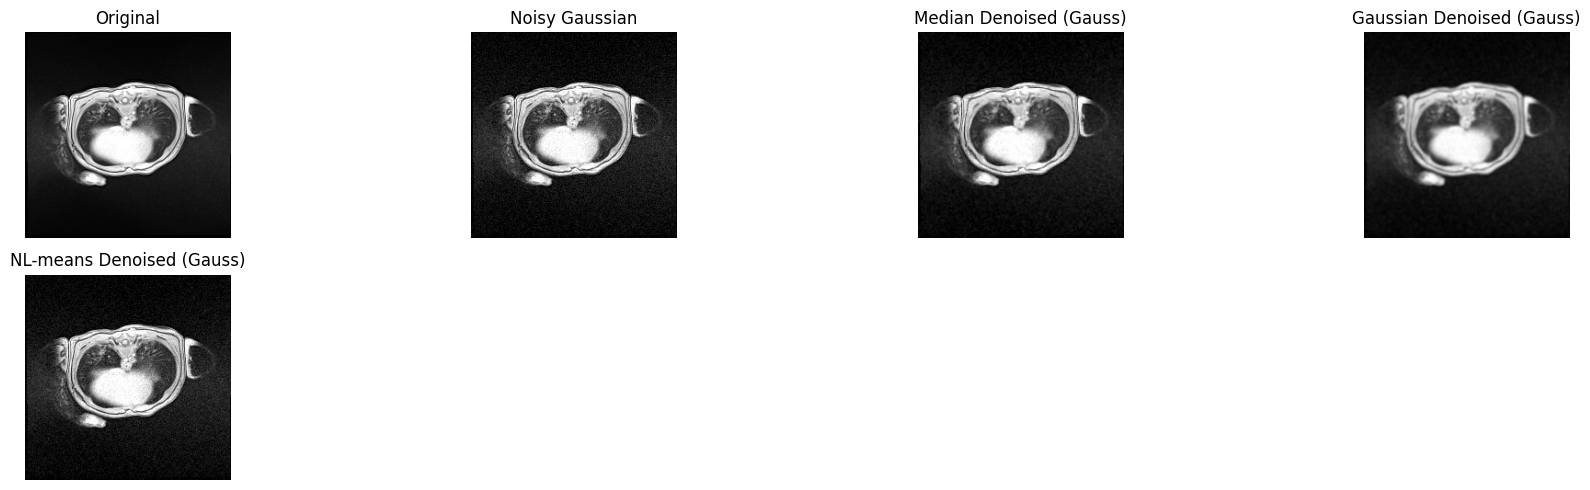


 Metrics for Image 1 (Gaussian Noise) 
Original                       PSNR=inf, SSIM=1.0000
Noisy Gaussian                 PSNR=28.649, SSIM=0.6005
Median Denoised (Gauss)        PSNR=30.067, SSIM=0.7567
Gaussian Denoised (Gauss)      PSNR=26.703, SSIM=0.8484
NL-means Denoised (Gauss)      PSNR=28.649, SSIM=0.6005


/usr/local/lib/python3.12/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


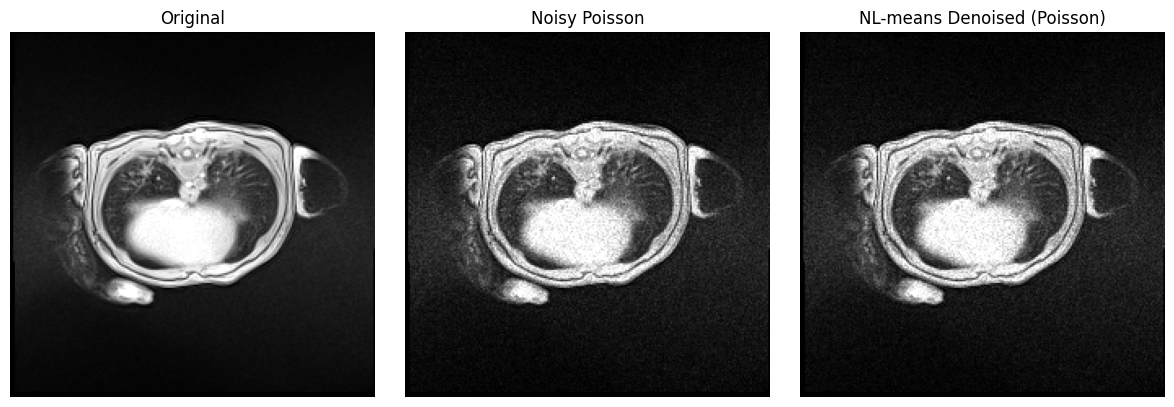


--- Metrics for Image 1 (Poisson Noise) ---
Original                       PSNR=inf, SSIM=1.0000
Noisy Poisson                  PSNR=28.462, SSIM=0.7499
NL-means Denoised (Poisson)    PSNR=28.462, SSIM=0.7499


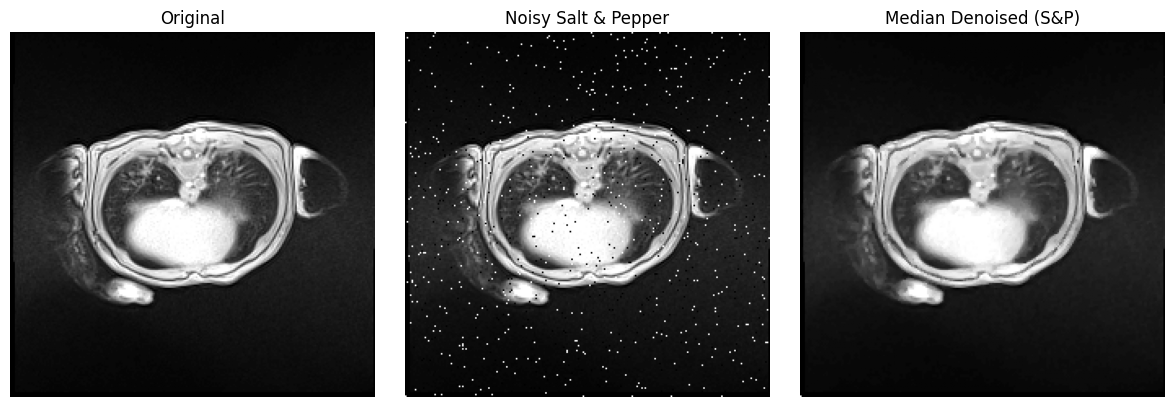


--- Metrics for Image 1 (Salt & Pepper Noise) ---
Original                       PSNR=inf, SSIM=1.0000
Noisy Salt & Pepper            PSNR=20.604, SSIM=0.6817
Median Denoised (S&P)          PSNR=32.359, SSIM=0.9530


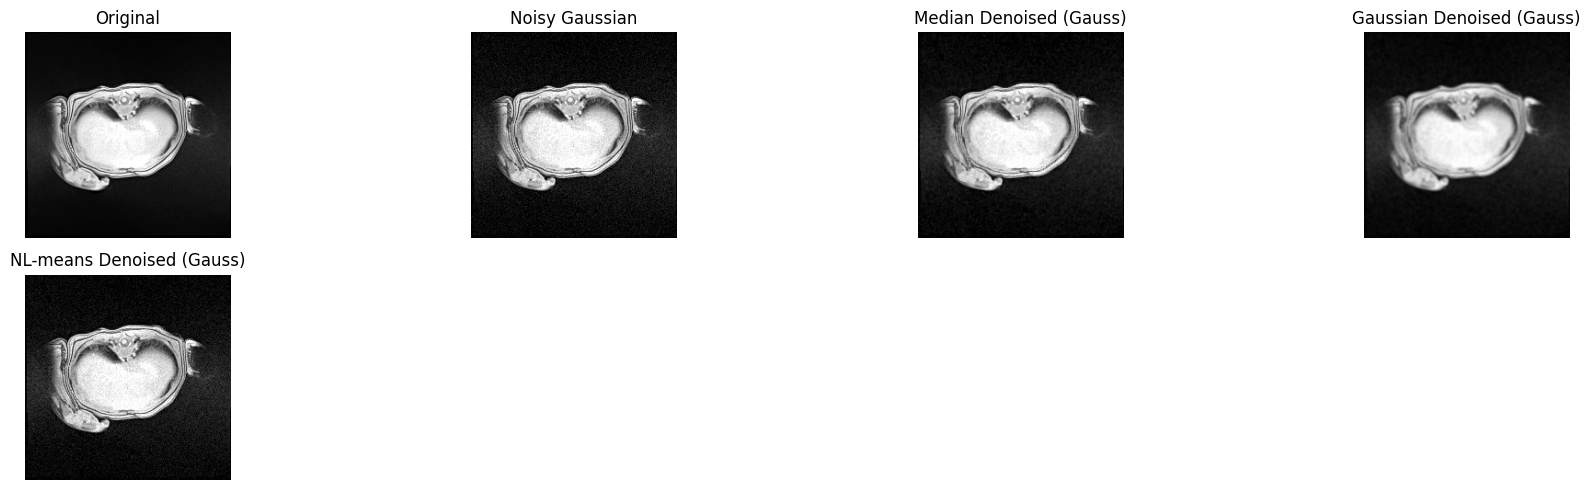


 Metrics for Image 2 (Gaussian Noise) 
Original                       PSNR=inf, SSIM=1.0000
Noisy Gaussian                 PSNR=28.674, SSIM=0.5980
Median Denoised (Gauss)        PSNR=29.290, SSIM=0.7467
Gaussian Denoised (Gauss)      PSNR=26.327, SSIM=0.8359
NL-means Denoised (Gauss)      PSNR=28.674, SSIM=0.5980


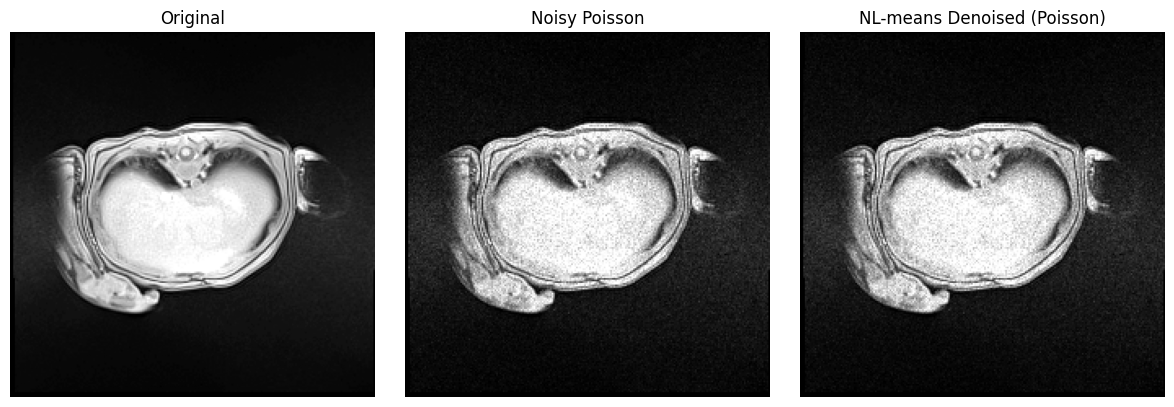


--- Metrics for Image 2 (Poisson Noise) ---
Original                       PSNR=inf, SSIM=1.0000
Noisy Poisson                  PSNR=27.877, SSIM=0.7309
NL-means Denoised (Poisson)    PSNR=27.877, SSIM=0.7309


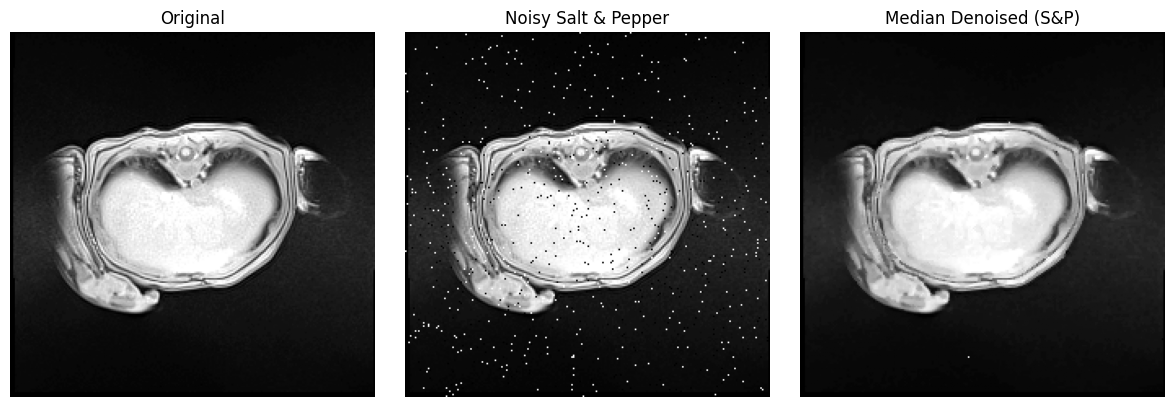


--- Metrics for Image 2 (Salt & Pepper Noise) ---
Original                       PSNR=inf, SSIM=1.0000
Noisy Salt & Pepper            PSNR=21.025, SSIM=0.6951
Median Denoised (S&P)          PSNR=31.270, SSIM=0.9413


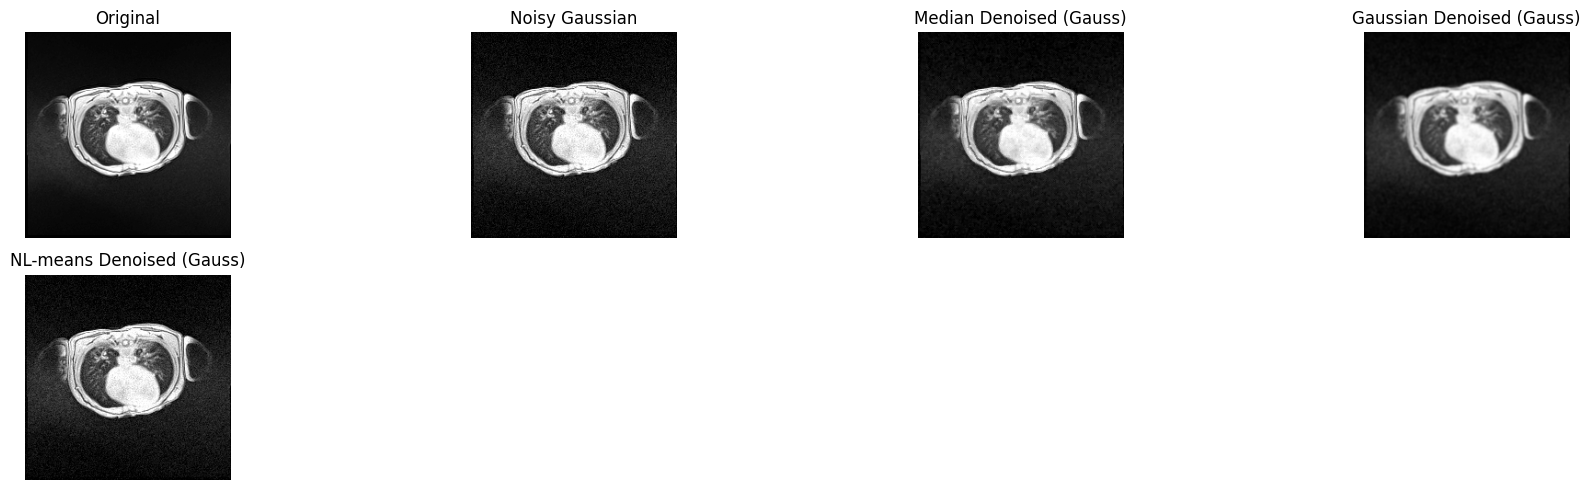


 Metrics for Image 3 (Gaussian Noise) 
Original                       PSNR=inf, SSIM=1.0000
Noisy Gaussian                 PSNR=28.584, SSIM=0.5915
Median Denoised (Gauss)        PSNR=29.835, SSIM=0.7429
Gaussian Denoised (Gauss)      PSNR=26.570, SSIM=0.8375
NL-means Denoised (Gauss)      PSNR=28.584, SSIM=0.5915


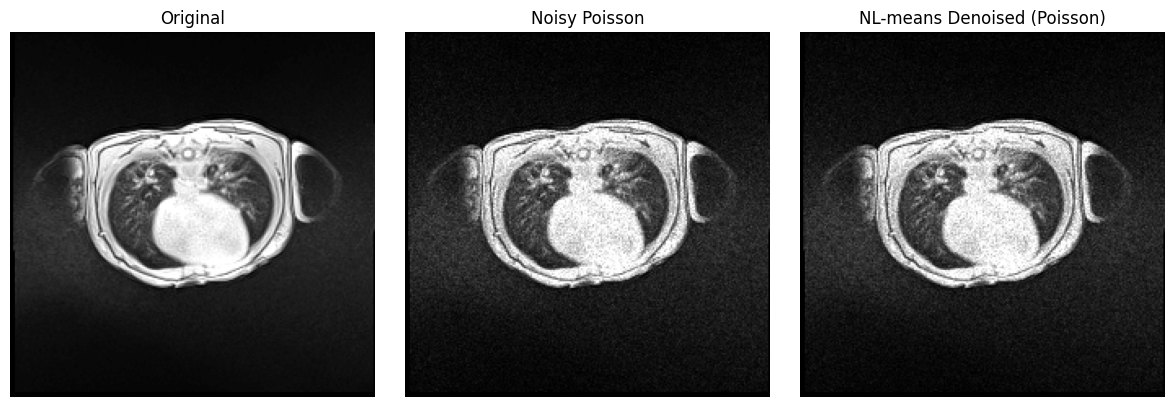


--- Metrics for Image 3 (Poisson Noise) ---
Original                       PSNR=inf, SSIM=1.0000
Noisy Poisson                  PSNR=28.414, SSIM=0.7352
NL-means Denoised (Poisson)    PSNR=28.414, SSIM=0.7352


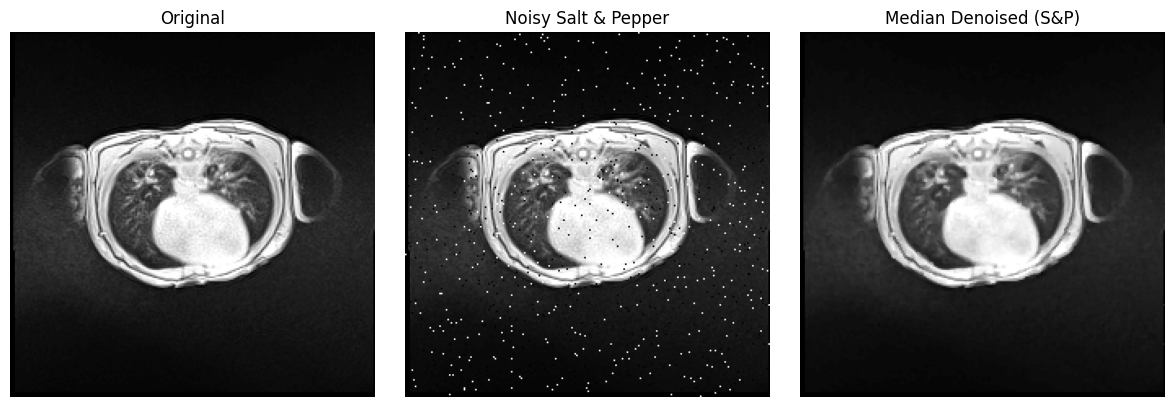


--- Metrics for Image 3 (Salt & Pepper Noise) ---
Original                       PSNR=inf, SSIM=1.0000
Noisy Salt & Pepper            PSNR=21.085, SSIM=0.6821
Median Denoised (S&P)          PSNR=32.421, SSIM=0.9434


In [15]:
import numpy as np
from skimage.util import random_noise
from skimage.filters import gaussian, median
from skimage.morphology import disk
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio as compute_psnr, structural_similarity as compute_ssim


def add_gaussian_noise(image, sigma=0.04):
    return random_noise(image, mode='gaussian', var=sigma**2)

def add_poisson_noise(image):
    return random_noise(image, mode='poisson')

def add_salt_pepper_noise(image, amount=0.02):
    return random_noise(image, mode='s&p', amount=amount)

def denoise_median_filter(image, disk_size=1):
    return median(image, disk(disk_size))

def denoise_gaussian_filter(image, sigma=1.0):
    return gaussian(image, sigma=sigma)

def denoise_nlmeans_filter(image, h=0.1, fast_mode=True):
    sigma_est = np.mean(estimate_sigma(image, channel_axis=None))
    return denoise_nl_means(image, h=h * sigma_est, fast_mode=fast_mode, patch_size=5, patch_distance=6, channel_axis=None)

def psnr_metric(image_true, image_test, data_range):
    return compute_psnr(image_true, image_test, data_range=data_range)

def ssim_metric(image_true, image_test, data_range):
    return compute_ssim(image_true, image_test, data_range=data_range, channel_axis=None)

images, paths = load_three_random_images(ROOT)

for i, img in enumerate(images, start=1):
    results = process_image(img)
    evaluate_and_show(results, i)

In [17]:
!pip install bm3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.0/862.0 kB 14.3 MB/s eta 0:00:00


In [18]:
import bm3d
import numpy as np
from skimage.util import random_noise
from skimage.restoration import estimate_sigma
from skimage.metrics import peak_signal_noise_ratio as compute_psnr, structural_similarity as compute_ssim
import matplotlib.pyplot as plt

def add_gaussian_noise(image, sigma=0.04):
    return random_noise(image, mode='gaussian', var=sigma**2)

def add_poisson_noise(image):
    return random_noise(image, mode='poisson')

def add_salt_pepper_noise(image, amount=0.02):
    return random_noise(image, mode='s&p', amount=amount)

def psnr_metric(image_true, image_test, data_range):
    return compute_psnr(image_true, image_test, data_range=data_range)

def ssim_metric(image_true, image_test, data_range):
    return compute_ssim(image_true, image_test, data_range=data_range, channel_axis=None)

def show_image_grid(images, titles=None, cmap="gray", figsize=(12,6)):
    n = len(images)
    cols = min(n, 4)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img, cmap=cmap)
        ax.axis("off")
        if titles:
            ax.set_title(titles[i])
    plt.tight_layout()
    plt.show()

In [19]:
def process_image_bm3d(img):
    noisy_gauss = add_gaussian_noise(img, sigma=0.04)
    noisy_poisson = add_poisson_noise(img)
    noisy_sp = add_salt_pepper_noise(img, amount=0.02)

    sigma_est_gauss = np.mean(estimate_sigma(noisy_gauss, channel_axis=None, average_sigmas=True))
    den_bm3d_gauss = bm3d.bm3d(noisy_gauss, sigma_psd=sigma_est_gauss, stage_arg=bm3d.BM3DStages.ALL_STAGES)

    sigma_est_poisson = np.mean(estimate_sigma(noisy_poisson, channel_axis=None, average_sigmas=True))
    den_bm3d_poisson = bm3d.bm3d(noisy_poisson, sigma_psd=sigma_est_poisson, stage_arg=bm3d.BM3DStages.ALL_STAGES)

    sigma_est_sp = np.mean(estimate_sigma(noisy_sp, channel_axis=None, average_sigmas=True))
    den_bm3d_sp = bm3d.bm3d(noisy_sp, sigma_psd=sigma_est_sp, stage_arg=bm3d.BM3DStages.ALL_STAGES)

    return {
        "original": img,
        "noisy_gaussian": noisy_gauss,
        "den_bm3d_gauss": den_bm3d_gauss,
        "noisy_poisson": noisy_poisson,
        "den_bm3d_poisson": den_bm3d_poisson,
        "noisy_sp": noisy_sp,
        "den_bm3d_sp": den_bm3d_sp
    }

In [20]:
def evaluate_and_show_bm3d(results_dict_bm3d, index):
    orig = results_dict_bm3d["original"]

    noisy_gauss = results_dict_bm3d["noisy_gaussian"]
    den_bm3d_gauss = results_dict_bm3d["den_bm3d_gauss"]

    images_gauss = [
        orig,
        noisy_gauss,
        den_bm3d_gauss
    ]
    titles_gauss = [
        f"Original",
        f"Noisy Gaussian",
        "BM3D Denoised (Gauss)"
    ]
    show_image_grid(images_gauss, titles_gauss, figsize=(12, 4))

    print(f"\nBM3D Metrics for Image {index} (Gaussian Noise) ")
    metrics_data_gauss = {
        "Original": orig,
        "Noisy Gaussian": noisy_gauss,
        "BM3D Denoised (Gauss)": den_bm3d_gauss
    }
    for title, img in metrics_data_gauss.items():
        p = psnr_metric(orig, img, data_range=1.0)
        s = ssim_metric(orig, img, data_range=1.0)
        print(f"{title:<30} PSNR={p:.3f}, SSIM={s:.4f}")

    noisy_poisson = results_dict_bm3d["noisy_poisson"]
    den_bm3d_poisson = results_dict_bm3d["den_bm3d_poisson"]

    images_poisson = [
        orig,
        noisy_poisson,
        den_bm3d_poisson
    ]
    titles_poisson = [
        f"Original",
        f"Noisy Poisson",
        "BM3D Denoised (Poisson)"
    ]
    show_image_grid(images_poisson, titles_poisson, figsize=(12, 4))

    print(f"\nBM3D Metrics for Image {index} (Poisson Noise)")
    metrics_data_poisson = {
        "Original": orig,
        "Noisy Poisson": noisy_poisson,
        "BM3D Denoised (Poisson)": den_bm3d_poisson
    }
    for title, img in metrics_data_poisson.items():
        p = psnr_metric(orig, img, data_range=1.0)
        s = ssim_metric(orig, img, data_range=1.0)
        print(f"{title:<30} PSNR={p:.3f}, SSIM={s:.4f}")

    noisy_sp = results_dict_bm3d["noisy_sp"]
    den_bm3d_sp = results_dict_bm3d["den_bm3d_sp"]

    images_sp = [
        orig,
        noisy_sp,
        den_bm3d_sp
    ]
    titles_sp = [
        f"Original",
        f"Noisy Salt & Pepper",
        "BM3D Denoised (S&P)"
    ]
    show_image_grid(images_sp, titles_sp, figsize=(12, 4))

    print(f"\n--- BM3D Metrics for Image {index} (Salt & Pepper Noise) ---")
    metrics_data_sp = {
        "Original": orig,
        "Noisy Salt & Pepper": noisy_sp,
        "BM3D Denoised (S&P)": den_bm3d_sp
    }
    for title, img in metrics_data_sp.items():
        p = psnr_metric(orig, img, data_range=1.0)
        s = ssim_metric(orig, img, data_range=1.0)
        print(f"{title:<30} PSNR={p:.3f}, SSIM={s:.4f}")

Selected folder: /content/drive/MyDrive/Nifti-data/BPD-Neo-06/image
Loaded 3 images:
 - /content/drive/MyDrive/Nifti-data/BPD-Neo-06/image/slice_011.png
 - /content/drive/MyDrive/Nifti-data/BPD-Neo-06/image/slice_014.png
 - /content/drive/MyDrive/Nifti-data/BPD-Neo-06/image/slice_051.png
       BM3D DENOISING RESULTS         

Processing Image 1 for BM3D...


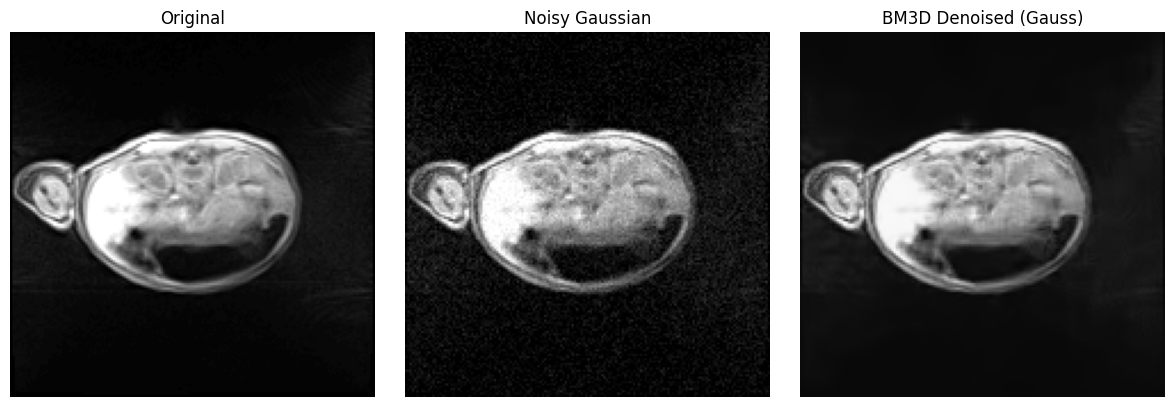


BM3D Metrics for Image 1 (Gaussian Noise) 
Original                       PSNR=inf, SSIM=1.0000
Noisy Gaussian                 PSNR=29.131, SSIM=0.6195
BM3D Denoised (Gauss)          PSNR=35.034, SSIM=0.9173


/usr/local/lib/python3.12/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


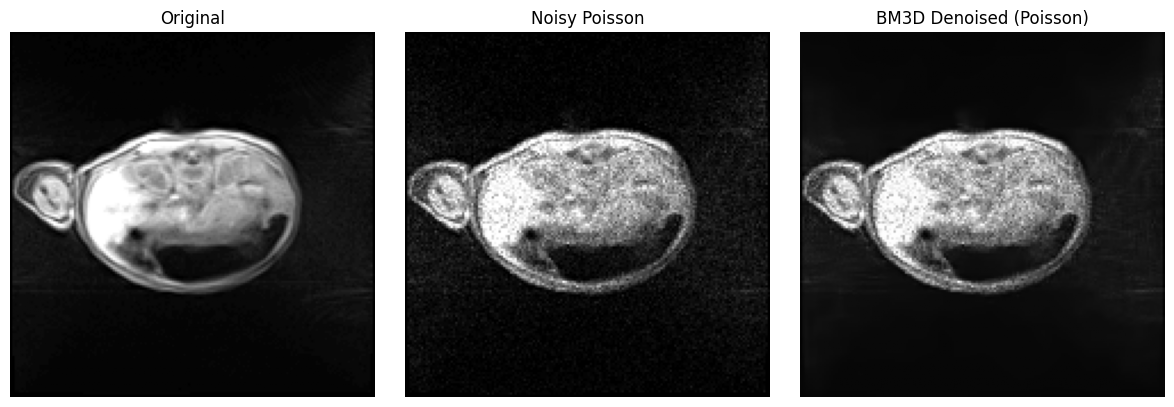


BM3D Metrics for Image 1 (Poisson Noise)
Original                       PSNR=inf, SSIM=1.0000
Noisy Poisson                  PSNR=26.351, SSIM=0.7143
BM3D Denoised (Poisson)        PSNR=27.376, SSIM=0.8842


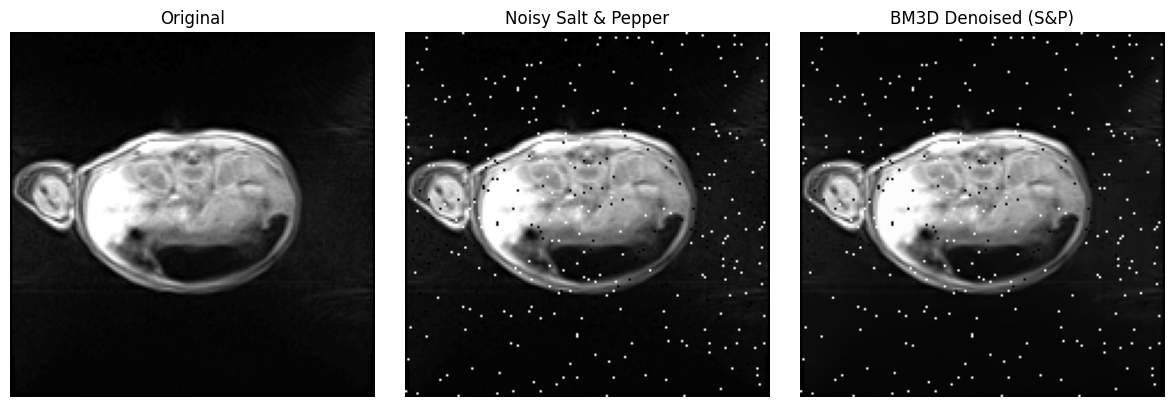


--- BM3D Metrics for Image 1 (Salt & Pepper Noise) ---
Original                       PSNR=inf, SSIM=1.0000
Noisy Salt & Pepper            PSNR=20.596, SSIM=0.6847
BM3D Denoised (S&P)            PSNR=20.602, SSIM=0.6762

Processing Image 2 for BM3D...


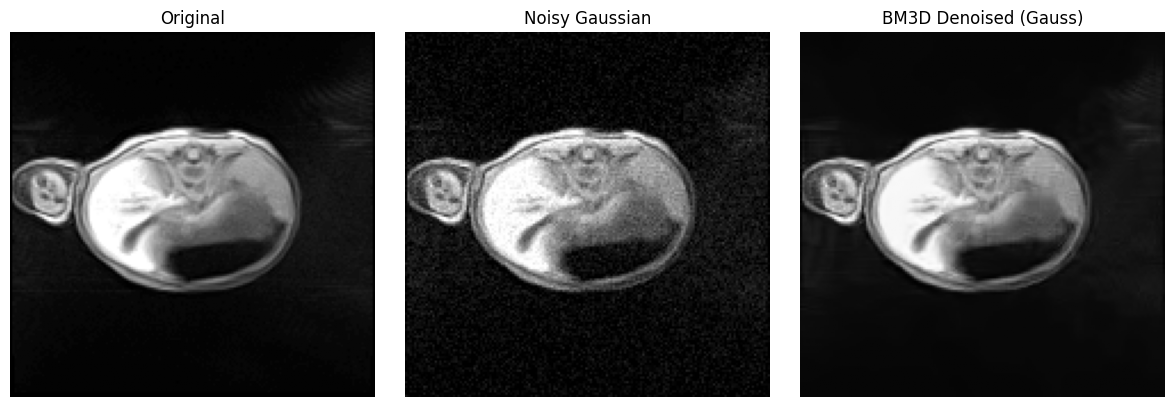


BM3D Metrics for Image 2 (Gaussian Noise) 
Original                       PSNR=inf, SSIM=1.0000
Noisy Gaussian                 PSNR=29.135, SSIM=0.6123
BM3D Denoised (Gauss)          PSNR=35.303, SSIM=0.9166


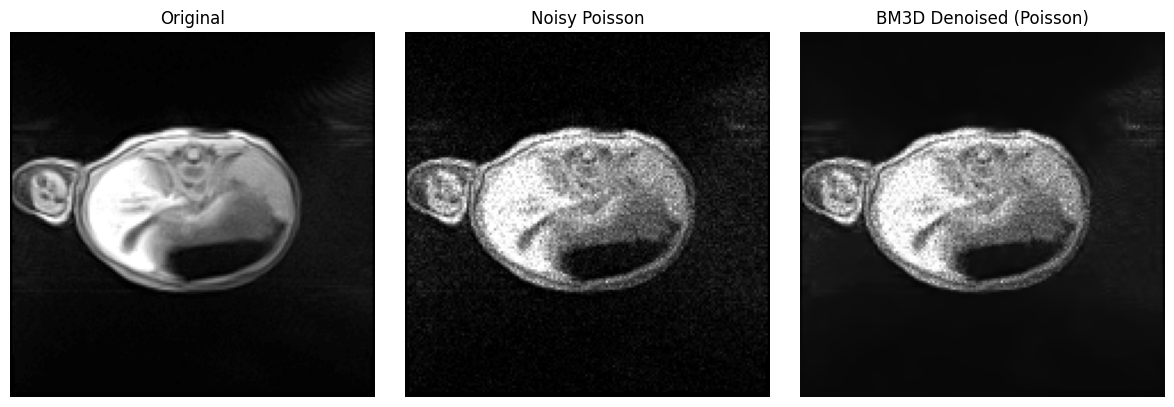


BM3D Metrics for Image 2 (Poisson Noise)
Original                       PSNR=inf, SSIM=1.0000
Noisy Poisson                  PSNR=26.497, SSIM=0.7101
BM3D Denoised (Poisson)        PSNR=27.613, SSIM=0.8840


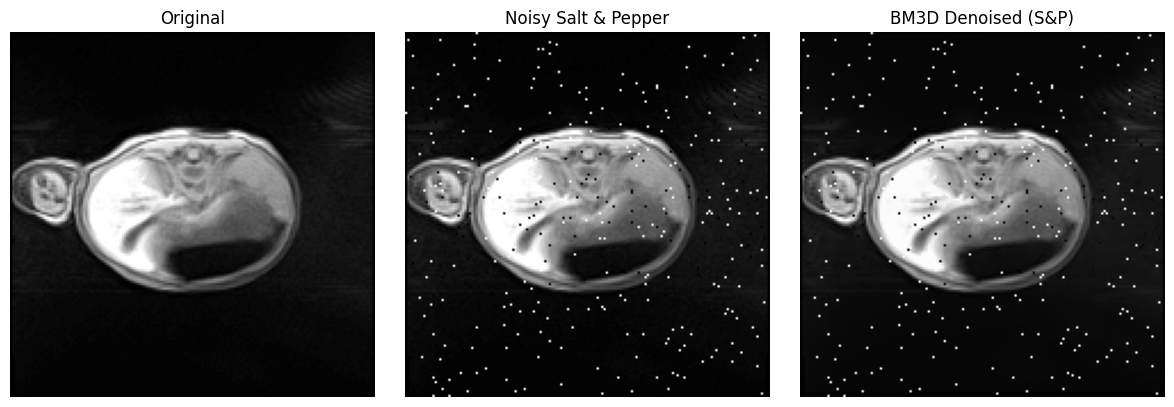


--- BM3D Metrics for Image 2 (Salt & Pepper Noise) ---
Original                       PSNR=inf, SSIM=1.0000
Noisy Salt & Pepper            PSNR=20.780, SSIM=0.6727
BM3D Denoised (S&P)            PSNR=20.782, SSIM=0.6651

Processing Image 3 for BM3D...


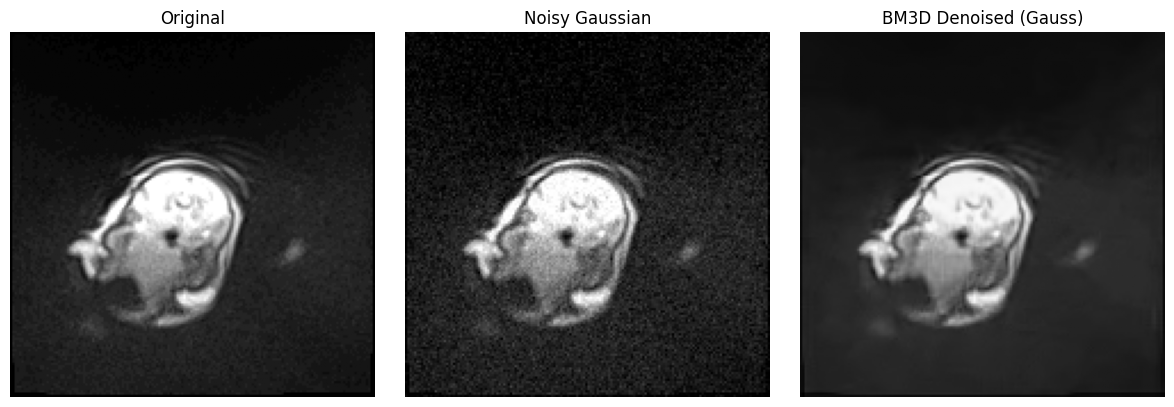


BM3D Metrics for Image 3 (Gaussian Noise) 
Original                       PSNR=inf, SSIM=1.0000
Noisy Gaussian                 PSNR=28.485, SSIM=0.5809
BM3D Denoised (Gauss)          PSNR=34.907, SSIM=0.8678


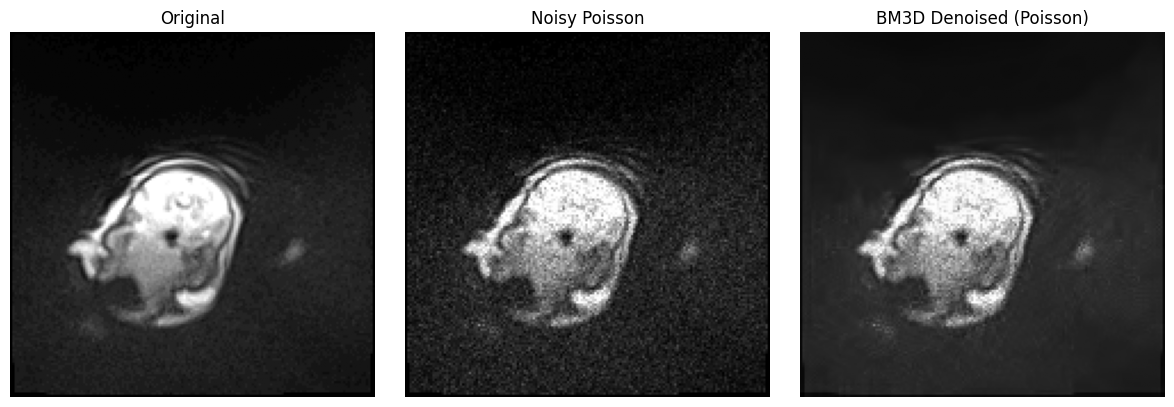


BM3D Metrics for Image 3 (Poisson Noise)
Original                       PSNR=inf, SSIM=1.0000
Noisy Poisson                  PSNR=26.312, SSIM=0.5915
BM3D Denoised (Poisson)        PSNR=29.428, SSIM=0.8428


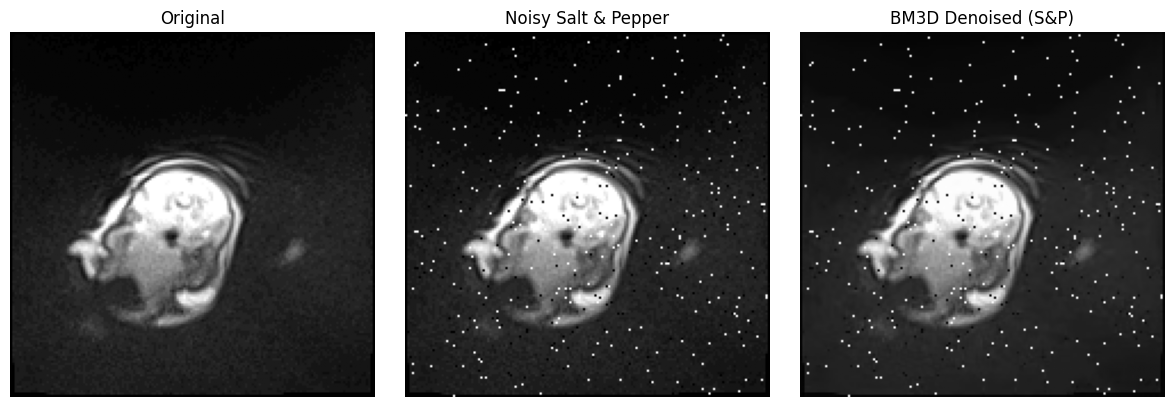


--- BM3D Metrics for Image 3 (Salt & Pepper Noise) ---
Original                       PSNR=inf, SSIM=1.0000
Noisy Salt & Pepper            PSNR=20.870, SSIM=0.6440
BM3D Denoised (S&P)            PSNR=20.879, SSIM=0.6162


In [21]:
images_for_bm3d, paths_for_bm3d = load_three_random_images(ROOT)

print("       BM3D DENOISING RESULTS         ")

for i, img in enumerate(images_for_bm3d, start=1):
    print(f"\nProcessing Image {i} for BM3D...")
    bm3d_results = process_image_bm3d(img)
    evaluate_and_show_bm3d(bm3d_results, i)

In [22]:
import os, glob, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from skimage import io, img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.util import random_noise

tf.random.set_seed(42)
np.random.seed(42)


In [23]:
ROOT = "/content/drive/MyDrive/Nifti-data"

def list_all_images(root):
    folders = []
    for d in sorted(os.listdir(root)):
        if d.startswith("BPD-Neo"):
            img_dir = os.path.join(root, d, "image")
            if os.path.exists(img_dir):
                folders.append(img_dir)

    all_imgs = []
    for f in folders:
        all_imgs += glob.glob(os.path.join(f, "*.png"))
        all_imgs += glob.glob(os.path.join(f, "*.jpg"))
        all_imgs += glob.glob(os.path.join(f, "*.jpeg"))

    return sorted(all_imgs)

all_image_paths = list_all_images(ROOT)
print("Total images found:", len(all_image_paths))


Total images found: 2408


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

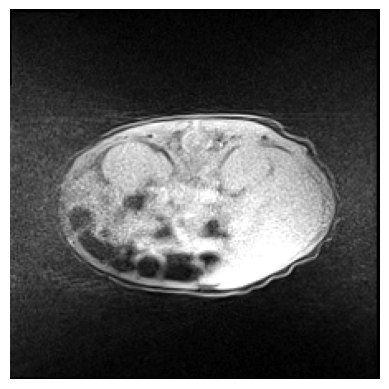

In [25]:
def load_and_preprocess(path):
    img = load_png_image(path)
    img = np.expand_dims(img, axis=-1)
    return img

test_img = load_and_preprocess(all_image_paths[0])
plt.imshow(test_img[...,0], cmap='gray'); plt.axis('off')

In [34]:
IMG_SIZE = 128

def load_image_tf(path):
    img_bytes = tf.io.read_file(path)

    img = tf.io.decode_image(img_bytes, channels=1, dtype=tf.float32)

    if img.shape.rank is None:
        tf.print(f"WARNING: Image at {path} could not be properly decoded (rank is None). Returning zeros.")
        return tf.zeros((IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32)

    if tf.rank(img) != 3 or tf.reduce_any(tf.less_equal(tf.shape(img), 0)):
        tf.print(f"WARNING: Decoded image at {path} has invalid rank {tf.rank(img)} or shape {tf.shape(img)}. Returning zeros.")
        return tf.zeros((IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32)

    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img

In [31]:
def add_gaussian_noise_tf(img, sigma=0.04):
    noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=sigma, dtype=tf.float32)
    return tf.clip_by_value(img + noise, 0.0, 1.0)


In [32]:
def build_tf_dataset(paths, batch_size=16, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(paths)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))

    def _process(path):
        clean = load_image_tf(path)
        noisy = add_gaussian_noise_tf(clean)
        return noisy, clean

    ds = ds.map(_process, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [35]:
train_ds = build_tf_dataset(train_paths, batch_size=16)
val_ds   = build_tf_dataset(val_paths, batch_size=16, shuffle=False)


In [36]:
from tensorflow.keras import layers, models

def build_dncnn():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inp)

    for _ in range(6):
        x = layers.Conv2D(64, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

    x = layers.Conv2D(1, 3, padding='same')(x)
    out = layers.Subtract()([inp, x])

    model = models.Model(inp, out)
    return model

model = build_dncnn()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 224,321 (876.25 KB)

 Trainable params: 223,553 (873.25 KB)

 Non-trainable params: 768 (3.00 KB)

In [38]:
ROOT = "/content/drive/MyDrive/Nifti-data"

def get_all_images(root):
    all_imgs = []
    for folder in sorted(os.listdir(root)):
        fpath = os.path.join(root, folder, "image")
        if os.path.exists(fpath):
            files = glob.glob(os.path.join(fpath, "*.png"))
            files += glob.glob(os.path.join(fpath, "*.jpg"))
            all_imgs += files
    return sorted(all_imgs)

all_paths = get_all_images(ROOT)
print("Total images:", len(all_paths))


Total images: 2408


In [39]:
IMG_SIZE = 128

def safe_load(path):
    try:
        img = io.imread(path, as_gray=True)
        img = img_as_float(img).astype(np.float32)
        img = tf.image.resize(img[..., None], (IMG_SIZE, IMG_SIZE)).numpy()
        return img
    except:
        print("Skipping corrupted file:", path)
        return None


In [40]:
random.shuffle(all_paths)

train_paths = all_paths[:2000]
val_paths   = all_paths[2000:2300]
test_paths  = all_paths[2300:2400]

print(len(train_paths), len(val_paths), len(test_paths))


2000 300 100


In [41]:
def add_noise(img, sigma=0.04):
    n = np.random.normal(0, sigma, img.shape)
    return np.clip(img + n, 0, 1)

def generator(image_paths, batch_size=8):
    while True:
        batch_clean = []
        batch_noisy = []
        for p in random.sample(image_paths, batch_size):
            clean = safe_load(p)
            if clean is None:
                continue
            noisy = add_noise(clean)
            batch_clean.append(clean)
            batch_noisy.append(noisy)

        yield np.array(batch_noisy), np.array(batch_clean)


In [42]:
train_gen = generator(train_paths, batch_size=8)
val_gen   = generator(val_paths, batch_size=8)


In [43]:
from tensorflow.keras import layers, models

def build_dncnn():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inp)
    for _ in range(5):
        x = layers.Conv2D(64, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    x = layers.Conv2D(1, 3, padding='same')(x)
    out = layers.Subtract()([inp, x])
    return models.Model(inp, out)

model = build_dncnn()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_6[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_7[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_8[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_9[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 187,137 (731.00 KB)

 Trainable params: 186,497 (728.50 KB)

 Non-trainable params: 640 (2.50 KB)

In [45]:
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=200,
    validation_steps=50,
    epochs=15
)


Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - loss: 0.0137 - val_loss: 0.0012
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 98s 491ms/step - loss: 4.0743e-04 - val_loss: 7.8771e-04
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - loss: 3.5828e-04 - val_loss: 4.6791e-04
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 35s 176ms/step - loss: 3.2936e-04 - val_loss: 3.2885e-04
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - loss: 3.0494e-04 - val_loss: 3.3306e-04
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - loss: 2.9011e-04 - val_loss: 3.1904e-04
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 3.0438e-04 - val_loss: 4.0501e-04
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - loss: 2.8228e-04 - val_loss: 2.9870e-04
Epoch 9/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - loss: 2.8391e-04 - val_loss: 2.9270e-04
Epoch 10/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - loss: 2.9888e-04 - val_loss: 3.3595e-04
Epoch 11/15
200/200 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
PSNR: 37.96342410659102
SSIM: 0.9450662705053151


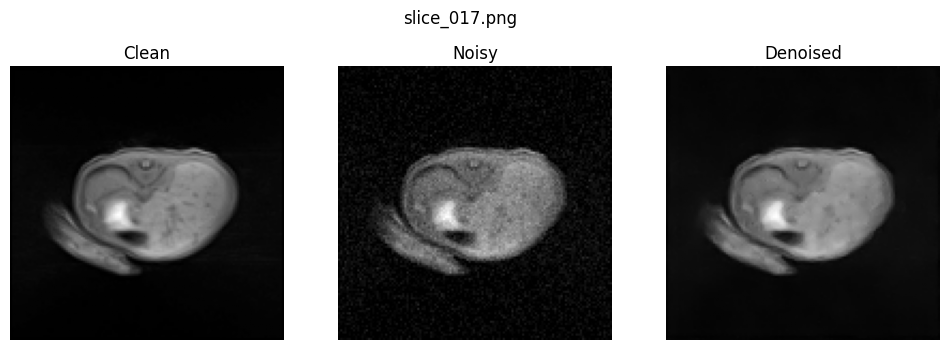

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
PSNR: 36.822008113944854
SSIM: 0.9483237328612013


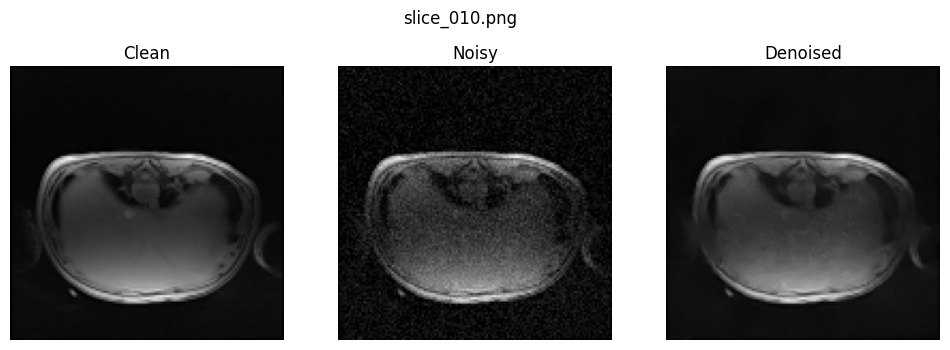

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
PSNR: 37.486991048687194
SSIM: 0.9393807402287591


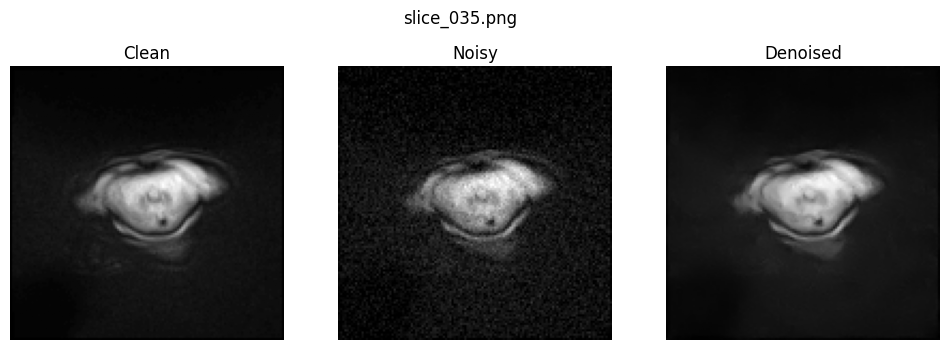

In [46]:
def show_triplet(clean, noisy, denoised, title=""):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(clean[:,:,0], cmap='gray'); plt.title("Clean"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(noisy[:,:,0], cmap='gray'); plt.title("Noisy"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(denoised[:,:,0], cmap='gray'); plt.title("Denoised"); plt.axis('off')
    plt.suptitle(title)
    plt.show()

for p in random.sample(test_paths, 3):
    clean = safe_load(p)
    noisy = add_noise(clean)
    denoised = model.predict(noisy[None])[0]

    print("PSNR:", psnr(clean[:,:,0], denoised[:,:,0]))
    print("SSIM:", ssim(clean[:,:,0], denoised[:,:,0], data_range=1.0))

    show_triplet(clean, noisy, denoised, title=os.path.basename(p))
